<a href="https://colab.research.google.com/github/Haileyyyyyyyy/pytorchstudy/blob/main/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)

In [ ]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        # 컨볼루션 계층 정의
        # 3 개의 입력이미지 채널, 6 개의 출력특징 맵(필터) 5x5 컨볼루션 커널 사용
        # 아래 코드에서는 3개의 이미지 채널 사용(원래 초기모델은 단일채널) → RGB를 받아들이도록 수정
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 개의 입력이미지 채널, 16 개의 출력특징맵 5x5 컨볼루션 커널 사용
        self.cn2 = nn.Conv2d(6, 16, 5)

        # 완전연결 계층 정의 -> 1차원 벡터로 변환(평면화)
        # 크기 120,84,10의 완전연결계층
        # 16 * 5 * 5 -> 액티베이션 맵과 같은 크기인 컨볼루션 필터 사용 -> 완전연결계층
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 5x5 크기의 합성곱 커널 (32x32x1 -> 28x28x6)
        x = F.relu(self.cn1(x))
        # (2, 2) 윈도에 최대풀링 
        x = F.max_pool2d(x, (2, 2))
        # 5x5 크기의 합성곱 커널 (28x28x6 ->14x14x6)
        x = F.relu(self.cn2(x))
        # (2, 2) 윈도에 최대풀링
        x = F.max_pool2d(x, (2, 2))
        # 1차원 벡터로 변환(평면화)
        x = x.view(-1, self.flattened_features(x))
        # 완전연결 연산
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
def train(net, trainloader, optim, epoch):
    # 손실 초기화
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # 입력을 가져옴, 데이터는 [입력,레이블]의 리스트 
        # ip 는 입력이미지, and ground_truth ip가 속한 이미지의 출력 클래스
        ip, ground_truth = data

        # 매개변수인 경사를 0으로 설정 -> zero_grad()
        optim.zero_grad()

        # 순전파+역전파+최적화 단계
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step() # 역전파 단계에서 수집된 변화도로 매개변수 조정 ->.step()

        # 손실 업데이트
        loss_total += loss.item()
        
        # 손실 통계 출력
        if (i+1) % 1000 == 0:    # 100개 미니배치 간격으로 출력
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

In [ ]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            # 순전파 실행 -> net()
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            # 정확히 예측한 수
            success += (pred == ground_truth).sum().item()

    # 테스트셋에서 정확히 예측한 비율 출력
    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

In [ ]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)


# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


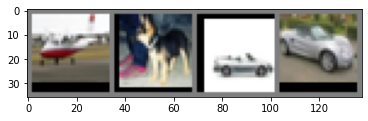

    plane  ||  dog  ||  car  ||  car


In [ ]:
# 이미지를 표시하는 함수 정의
def imageshow(image):
    # 이미지 비정규화
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# 훈련데이터셋의 샘플이미지
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 그리드에 이미지 표시
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [ ]:
# 옵티마이저 정의
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# 훈련루프 시작 
for epoch in range(50):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.773
[Epoch number : 1, Mini-batches:  2000] loss: 8.712
[Epoch number : 1, Mini-batches:  3000] loss: 8.291
[Epoch number : 1, Mini-batches:  4000] loss: 7.992
[Epoch number : 1, Mini-batches:  5000] loss: 7.727
[Epoch number : 1, Mini-batches:  6000] loss: 7.597

LeNet accuracy on 10000 images from test dataset: 47 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.253
[Epoch number : 2, Mini-batches:  2000] loss: 7.218
[Epoch number : 2, Mini-batches:  3000] loss: 7.088
[Epoch number : 2, Mini-batches:  4000] loss: 7.110
[Epoch number : 2, Mini-batches:  5000] loss: 7.061
[Epoch number : 2, Mini-batches:  6000] loss: 6.986

LeNet accuracy on 10000 images from test dataset: 54 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.792
[Epoch number : 3, Mini-batches:  2000] loss: 6.791
[Epoch number : 3, Mini-batches:  3000] loss: 6.685
[Epoch number : 3, Mini-batches:  4000] loss: 6.560
[Epoch number : 3, Mini-batches:  5000] loss: 6.671
[E

In [ ]:
# 모델파일을 로컬에 다운로드 
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

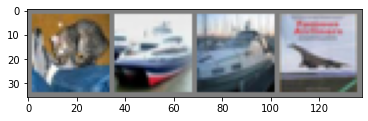

Label:         cat  ship  ship plane
Prediction:   ship   car truck plane


In [ ]:
# 테스트
# 테스트 데이터셋 로딩
d_iter = iter(testloader)
im, ground_truth = d_iter.next()

# 이미지와 실제값 출력
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# 모델 로딩
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# 모델 추론
op = lenet_cached(im)

# 예측 결과 출력
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [ ]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 66 %


In [ ]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 72 %
Model accuracy for class   car : 75 %
Model accuracy for class  bird : 48 %
Model accuracy for class   cat : 39 %
Model accuracy for class  deer : 70 %
Model accuracy for class   dog : 57 %
Model accuracy for class  frog : 73 %
Model accuracy for class horse : 72 %
Model accuracy for class  ship : 66 %
Model accuracy for class truck : 87 %
